In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [6]:
import zipfile
import os

# Path to the zip file
zip_file_path = 'f2.zip'  # Update with your ZIP file path

# Destination folder where the files will be extracted
extract_to = 'zip'  # Update with the desired extraction path

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")


Files extracted to zip


In [3]:
base_dir="F:\Freshness\dataset\Train"
class_labels=os.listdir(base_dir)
class_labels.sort()
print(class_labels)

['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd', 'fresh_capsicum', 'fresh_orange', 'fresh_tomato', 'stale_apple', 'stale_banana', 'stale_bitter_gourd', 'stale_capsicum', 'stale_orange', 'stale_tomato']


In [4]:
chart_data = []
for target in class_labels:
    path = os.path.join(base_dir, target)
    size = len(os.listdir(path))
    chart_data.append(size)
    print(f'The target {target} has {size} samples in the dataset')


The target fresh_apple has 100 samples in the dataset
The target fresh_banana has 100 samples in the dataset
The target fresh_bitter_gourd has 100 samples in the dataset
The target fresh_capsicum has 100 samples in the dataset
The target fresh_orange has 100 samples in the dataset
The target fresh_tomato has 100 samples in the dataset
The target stale_apple has 100 samples in the dataset
The target stale_banana has 100 samples in the dataset
The target stale_bitter_gourd has 100 samples in the dataset
The target stale_capsicum has 100 samples in the dataset
The target stale_orange has 100 samples in the dataset
The target stale_tomato has 100 samples in the dataset


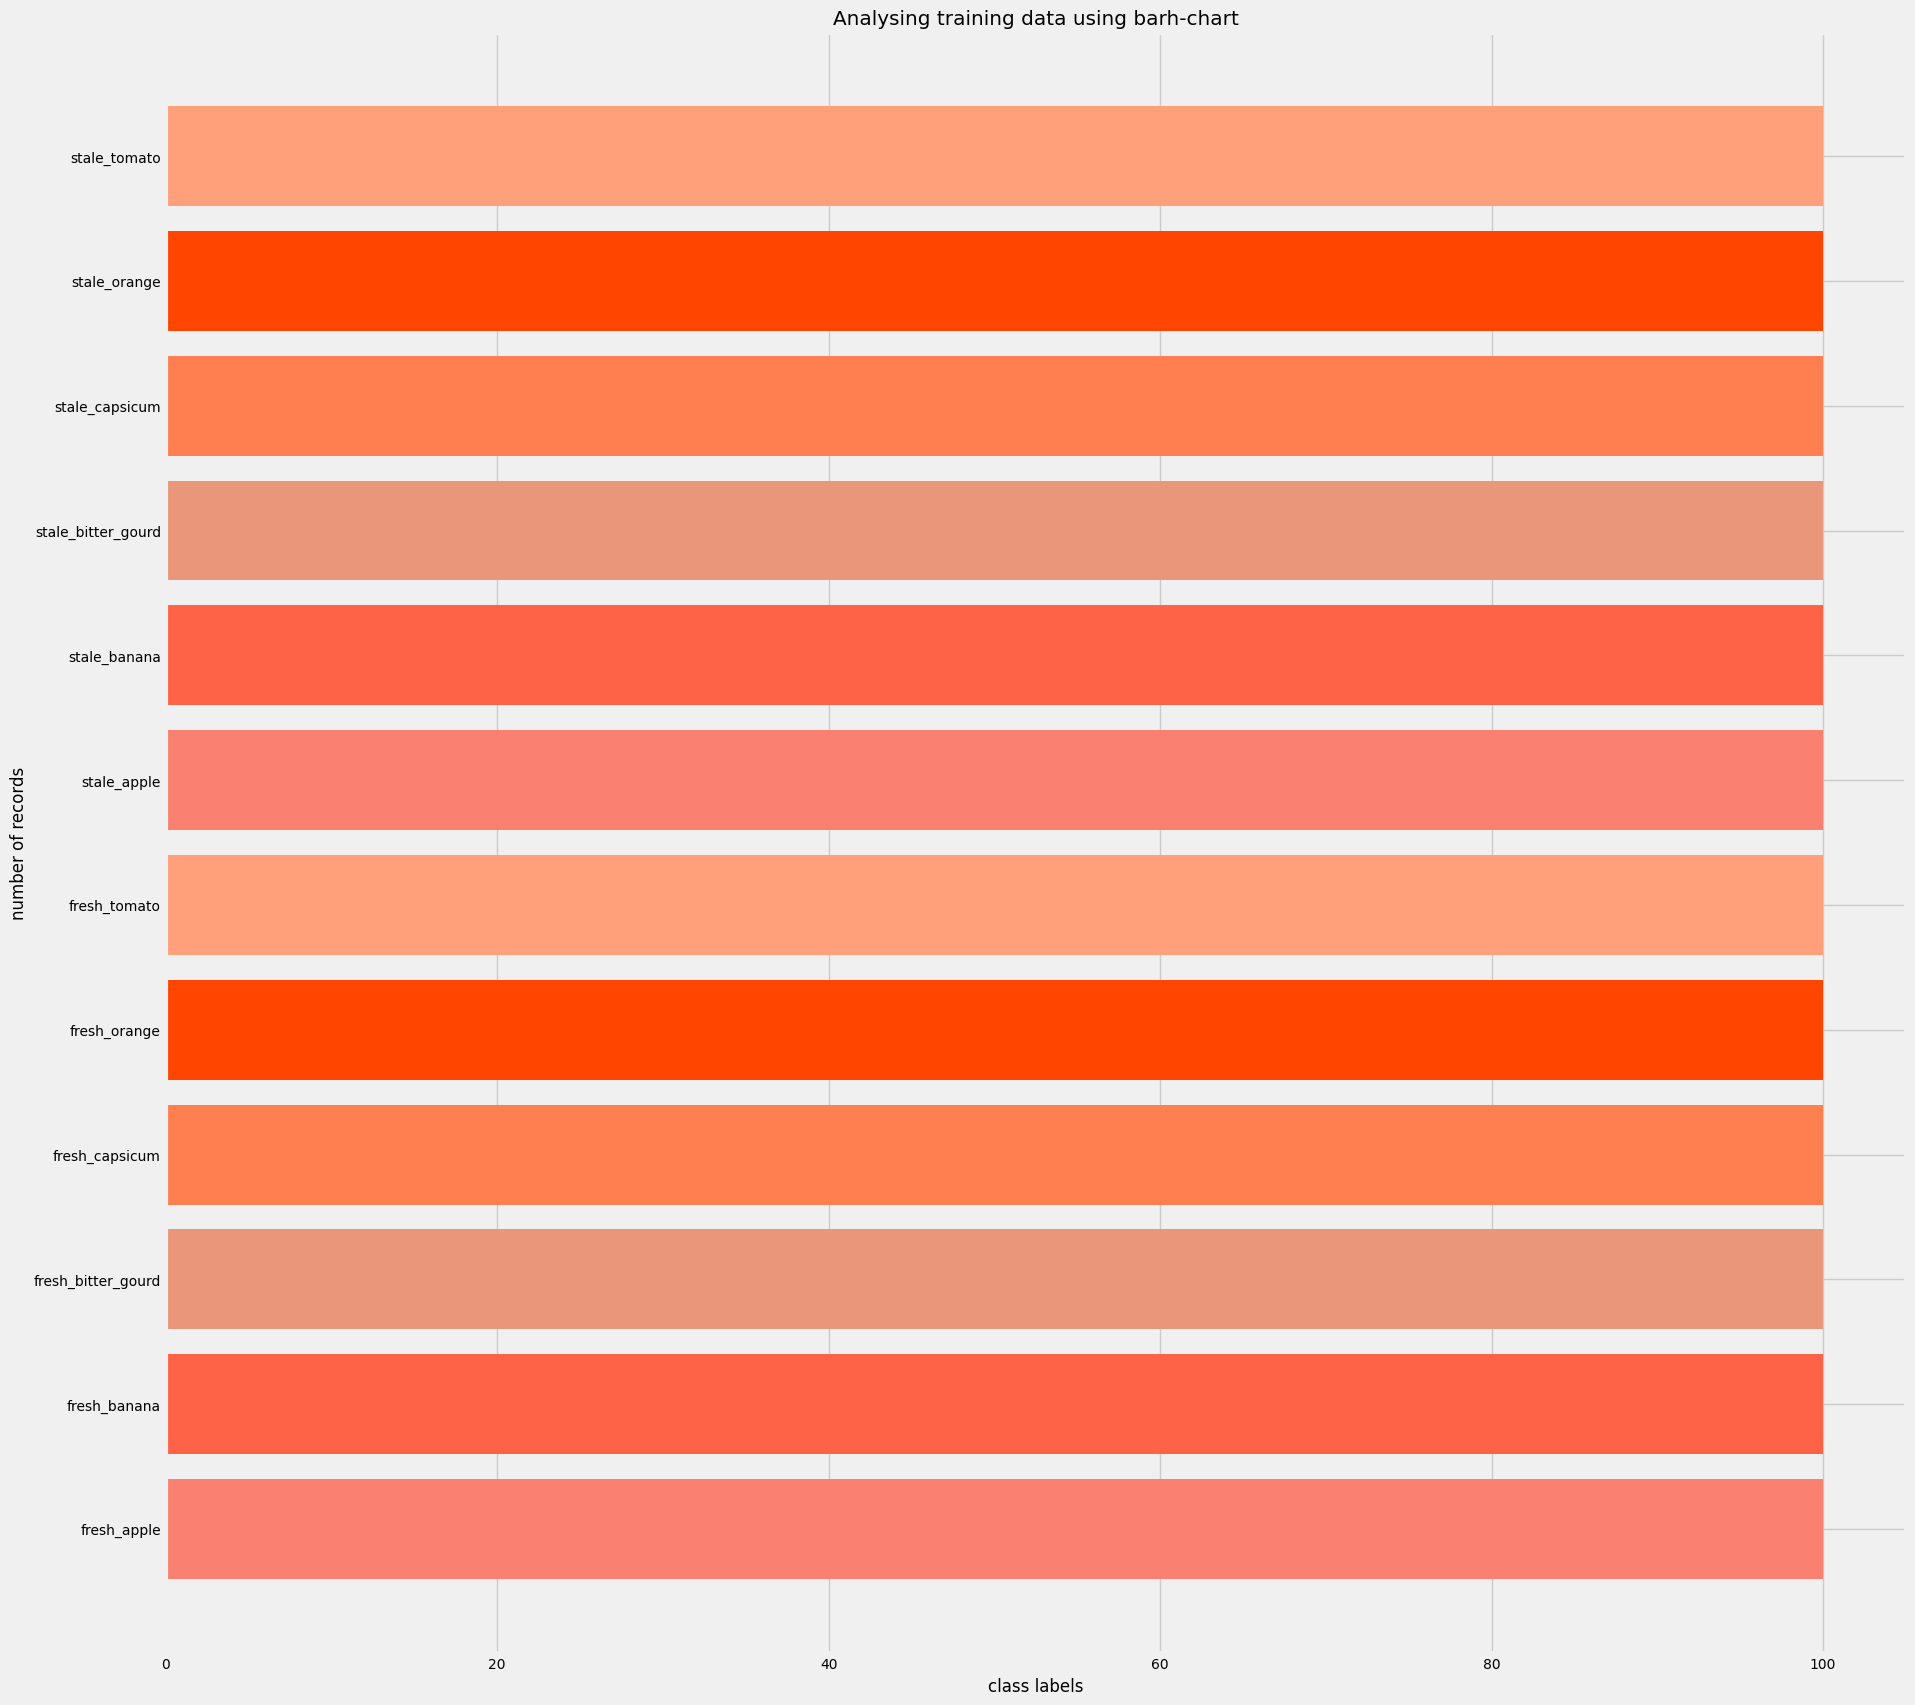

In [5]:
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(20,20))
    plt.rcParams["font.size"] = 10
    plt.barh(y=class_labels,
             width=chart_data,
             color=["salmon", "tomato", "darksalmon", "coral", "orangered", "lightsalmon"])
    plt.title(label="Analysing training data using barh-chart")
    plt.xlabel(xlabel="class labels")
    plt.ylabel(ylabel="number of records")
    plt.show()


In [6]:
data=[]
labels=[]
count=0
for target in tqdm(class_labels):
    path=os.path.join(base_dir,target)
    image_names=os.listdir(path)
    for image_name in image_names:
        image_path=os.path.join(path,image_name)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(128,128))
        image=np.array(image)
        image=image/225.0
        data.append(image)
        labels.append(count)
    count+=1

100%|██████████| 12/12 [00:24<00:00,  2.07s/it]


In [7]:
data=np.array(data)
labels=np.array(labels)
print(data.shape,labels.shape)

(1200, 128, 128, 3) (1200,)


In [8]:
from random import randint
def show_images(X,y,class_names):
    plt.figure(figsize=(10,10))
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        idx=randint(0,X.shape[0]-1)
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title("Class:{}".format(class_names[y[idx]]))
    plt.tight_layout()
    plt.show()

In [9]:
y=to_categorical(labels)
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.2,random_state=42,shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(960, 128, 128, 3) (240, 128, 128, 3) (960, 12) (240, 12)


In [10]:
# Load DenseNet201 model without the top classification layer
densenet_model = tf.keras.applications.DenseNet201(
    include_top=False,                # Exclude the fully connected layer at the top
    weights="imagenet",               # Load pre-trained weights from ImageNet
    input_tensor=None,                
    input_shape=(128, 128, 3),        # Input shape for your dataset
    pooling="max",                    # Use max pooling after the base model
    classes=1000                      # The original DenseNet201 was trained on 1000 classes
)
# Freeze the pre-trained layers so they are not updated during training
densenet_model.trainable = False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [11]:
# Add custom layers on top of the DenseNet model
inputs = densenet_model.input
m = tf.keras.layers.Dense(512, activation='relu')(densenet_model.output)
outputs = tf.keras.layers.Dense(len(class_labels), activation='softmax')(m)

# Create a custom model with the name 'model'
dense_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model")

In [12]:
# Compile the model with Adam optimizer and categorical crossentropy loss
dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history=dense_model.fit(X_train,y_train,batch_size=16,validation_data=(X_test,y_test),epochs=10)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 620ms/step - accuracy: 0.7077 - loss: 1.5274 - val_accuracy: 0.9750 - val_loss: 0.0645
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 572ms/step - accuracy: 0.9700 - loss: 0.0999 - val_accuracy: 0.9667 - val_loss: 0.1083
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 513ms/step - accuracy: 0.9934 - loss: 0.0271 - val_accuracy: 0.9750 - val_loss: 0.0730
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 515ms/step - accuracy: 0.9890 - loss: 0.0414 - val_accuracy: 0.9833 - val_loss: 0.0842
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 511ms/step - accuracy: 0.9995 - loss: 0.0070 - val_accuracy: 0.9792 - val_loss: 0.1025
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 519ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9792 - val_loss: 0.0904
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 512ms/step - accuracy: 1.0000 - loss: 5.6122e-04 - val_accuracy: 0.9792 - val_loss: 0.0792
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 511ms/step - accuracy: 1.0000 - loss: 2.5609e-04 - 

In [14]:
dense_model_prediction=dense_model.predict(X_test,batch_size=32,verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 


In [15]:
print(dense_model_prediction)

[[2.1311600e-11 7.4175563e-14 1.0975123e-08 ... 5.1959387e-10
  2.8935827e-13 1.0000000e+00]
 [3.7887512e-20 8.2426190e-22 3.7906225e-09 ... 8.6101545e-16
  8.3257653e-14 1.1061015e-15]
 [6.6530764e-10 1.0000000e+00 4.8197222e-14 ... 2.5010085e-09
  2.3800317e-10 2.3955881e-11]
 ...
 [1.4058615e-12 4.6123727e-18 1.6793544e-12 ... 1.6514557e-12
  7.6814691e-15 3.9006196e-08]
 [7.0743689e-10 3.4006412e-11 1.2570833e-06 ... 7.4724671e-09
  3.0348060e-10 9.9999738e-01]
 [1.0445262e-16 3.0780948e-20 1.7897132e-09 ... 8.0090769e-12
  2.2544916e-13 1.4525834e-13]]


In [16]:
dense_model_pred=[]
for i in range(len(dense_model_prediction)):
    dense_model_pred.append(np.argmax(dense_model_prediction[i]))

In [17]:
print(dense_model_pred)

[11, 8, 1, 4, 0, 11, 3, 9, 4, 8, 8, 0, 0, 8, 2, 1, 5, 7, 8, 4, 3, 6, 6, 3, 1, 2, 6, 5, 3, 5, 3, 8, 6, 7, 3, 5, 4, 0, 3, 6, 10, 1, 11, 3, 9, 3, 3, 0, 0, 2, 7, 11, 3, 1, 11, 3, 9, 11, 10, 3, 3, 1, 2, 0, 1, 9, 0, 4, 5, 4, 4, 1, 11, 0, 0, 4, 1, 0, 9, 8, 11, 2, 8, 1, 5, 10, 10, 1, 10, 6, 5, 4, 2, 3, 10, 6, 5, 9, 2, 1, 5, 1, 7, 6, 8, 7, 11, 9, 11, 9, 3, 8, 1, 9, 6, 10, 2, 1, 7, 1, 5, 9, 10, 10, 4, 11, 3, 1, 6, 6, 2, 11, 3, 2, 10, 6, 6, 4, 4, 9, 10, 6, 3, 6, 7, 5, 7, 10, 5, 6, 11, 3, 7, 2, 9, 4, 3, 2, 11, 3, 10, 9, 10, 2, 2, 8, 0, 8, 8, 0, 7, 9, 3, 2, 1, 5, 1, 11, 0, 7, 7, 8, 2, 10, 2, 9, 4, 8, 4, 5, 8, 6, 0, 8, 4, 1, 0, 9, 9, 2, 8, 9, 7, 9, 8, 2, 7, 7, 7, 11, 11, 7, 4, 8, 9, 2, 0, 2, 6, 5, 11, 9, 10, 9, 2, 5, 7, 0, 2, 6, 3, 1, 10, 6, 9, 3, 8, 5, 11, 8]


In [18]:
true_labels=[]
for i in range(len(y_test)):
    true_labels.append(np.argmax(y_test[i]))

In [19]:
print(true_labels)

[11, 8, 1, 4, 0, 11, 3, 9, 4, 8, 8, 0, 0, 8, 2, 1, 5, 7, 8, 4, 3, 6, 6, 3, 1, 2, 6, 5, 3, 5, 3, 8, 6, 7, 3, 5, 4, 0, 3, 6, 10, 1, 11, 3, 9, 3, 3, 0, 0, 2, 7, 11, 3, 1, 11, 3, 9, 11, 10, 3, 3, 1, 2, 0, 1, 9, 0, 4, 5, 4, 4, 1, 11, 0, 0, 4, 1, 0, 9, 8, 11, 2, 8, 1, 5, 10, 10, 1, 10, 6, 5, 4, 2, 3, 10, 6, 5, 9, 2, 1, 5, 1, 7, 0, 8, 7, 11, 9, 11, 9, 3, 8, 1, 9, 6, 10, 2, 1, 7, 1, 5, 9, 10, 10, 4, 11, 3, 1, 6, 6, 2, 11, 3, 2, 10, 6, 6, 4, 4, 9, 10, 6, 3, 6, 7, 5, 7, 6, 5, 4, 11, 3, 7, 2, 9, 4, 3, 2, 11, 3, 10, 9, 10, 2, 2, 8, 0, 8, 8, 0, 7, 9, 3, 2, 1, 5, 1, 11, 0, 7, 7, 8, 2, 10, 2, 9, 4, 8, 4, 5, 8, 6, 0, 8, 4, 1, 0, 9, 9, 2, 8, 9, 6, 9, 8, 2, 7, 7, 7, 11, 11, 7, 4, 8, 9, 2, 6, 2, 6, 5, 11, 9, 10, 9, 2, 5, 7, 0, 2, 6, 3, 1, 10, 6, 9, 3, 8, 5, 11, 8]


In [20]:
densemodel_accuracy=accuracy_score(y_true=true_labels,y_pred=dense_model_pred)
print(f'validation accuracy of DenseNet201 model is {densemodel_accuracy*100.0:.2f}%')

validation accuracy of DenseNet201 model is 97.92%


In [21]:
#from ipython.core.display import display,HTML
#display(HTML("<h1>DenseNet201 model classification report"))
print(classification_report(y_true=true_labels,y_pred=dense_model_pred,target_names=class_labels))

                    precision    recall  f1-score   support

       fresh_apple       0.94      0.94      0.94        18
      fresh_banana       1.00      1.00      1.00        21
fresh_bitter_gourd       1.00      1.00      1.00        23
    fresh_capsicum       1.00      1.00      1.00        25
      fresh_orange       1.00      0.94      0.97        18
      fresh_tomato       1.00      1.00      1.00        17
       stale_apple       0.90      0.86      0.88        21
      stale_banana       0.94      1.00      0.97        17
stale_bitter_gourd       1.00      1.00      1.00        22
    stale_capsicum       1.00      1.00      1.00        23
      stale_orange       0.94      1.00      0.97        16
      stale_tomato       1.00      1.00      1.00        19

          accuracy                           0.98       240
         macro avg       0.98      0.98      0.98       240
      weighted avg       0.98      0.98      0.98       240



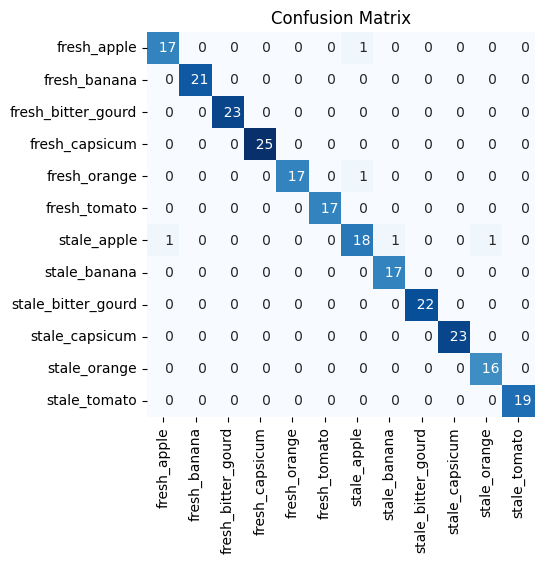

In [22]:
plt.figure(figsize=(5,5))
sns.heatmap(data=confusion_matrix(y_true=true_labels,y_pred=dense_model_pred),
            annot=True,
            fmt='4d',
            cbar=False,
            cmap=plt.cm.Blues,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title(label='Confusion Matrix')
plt.show()

In [23]:
dense_model.save(filepath="F:\Freshness\dataset\m.h5")